# ABOUT THIS NOTEBOOK
## Purpose
This notebook attempts to fit a neural network based model using TensorFlow.    
Results of the model fitting are analyzed.
## Input
'data_set.pickle' generated by 'data_processing.ipynb'.
## Output
Results of model fitting: plots, parameters and scores.
## Tasks Performed
* Load library packages
* Load pickle file
* Split data into train & test sets
    * Train: weeks 1 & 2, Test: week 3
    * Perform feature scaling
* Run the following experiments:
    * Single layer with learning rate, regularization
    * Add one hidden layer with batch gradient descent, dropout

## TensorBoard
http://blog.altoros.com/visualizing-tensorflow-graphs-with-tensorboard.html     
tensorboard --logdir=/tmp/tf_examples/my_model_1/

# LOAD LIBRARY PACKAGES

In [1]:
# Import the required library packages
import os
import re
import timeit
import itertools

import tensorflow as tf
import tensorflow.contrib.learn as skflow

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve

from six.moves import cPickle as pickle

# Settings for matplotlib, Seaborn
%matplotlib inline
sns.set_style('whitegrid')

# Set font sizes for matplots
plt.rcParams.update({'font.size': 15, 
                     'legend.fontsize': 'medium', 
                     'axes.titlesize': 'medium', 
                     'axes.labelsize': 'medium'})

print 'Read in packages from os, tensorflow, numpy, pandas, matplotlib, seaborn, sklearn & six'

Read in packages from os, tensorflow, numpy, pandas, matplotlib, seaborn, sklearn & six


# LOAD PICKLE FILE

In [2]:
pickle_file = 'data_set.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save
    print 'Loaded ptrain_set', pdata_set.shape
    
f.close()

Loaded ptrain_set (199584, 55)


In [3]:
pdata_set.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# SPLIT DATA INTO TRAIN & TEST SETS

## Use weeks 1 & 2 for training, week 3 for test

In [4]:
train_days     = range(1,15)
test_days      = range(15, 22)

X_train     = pdata_set[(pdata_set['num_day'].isin(train_days))]
X_test      = pdata_set[(pdata_set['num_day'].isin(test_days))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (133056, 55) (66528, 55) 




## Generate scaled features for train & test sets

In [5]:
import warnings
warnings.filterwarnings('ignore')

gap_predictors = ['demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3',
                  'poi_pc1', 'poi_pc2',
                  'tj_lvl1', 'tj_lvl2', 'tj_lvl3',
                  'ts_0', 'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7',
                  'pollution', 'temperature',
                  'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3'
                 ]  

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Use StandardScaler to achieve zero mean and unit variance
# Generate two scalers: input and target
input_scaler = StandardScaler().fit(pdata_set[gap_predictors])
target_scaler = StandardScaler().fit(pdata_set['gap'])

# Scale both training & test data
gX_train  = input_scaler.transform(X_train[gap_predictors])
gy_train  = target_scaler.transform(X_train['gap'])

gX_test = input_scaler.transform(X_test[gap_predictors])
gy_test = target_scaler.transform(X_test['gap'])

## Generate validation set

In [6]:
nn_predictors = [0,3,1,5,2,8,4,19]

train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(gX_train[:, nn_predictors], gy_train, test_size=0.33)
test_dataset = gX_test[:, nn_predictors]
test_labels  = gy_test

In [7]:
print train_dataset.shape, valid_dataset.shape, train_labels.shape, valid_labels.shape

(89147, 8) (43909, 8) (89147,) (43909,)


# IMPLEMENT FUNCTIONS FOR COMMON TASKS

## Scoring

In [8]:
# Generate Demand Supply Gap Metrics based on provided fit functions
# Assumes expected values for gap is in namesake column
def gap_estimate(**kwargs):
    """
    Generate scores for gap.
    
    Parameters
    ----------
    gX_train  : array containing train features
    gX_test   : array containing test features
    g_fitfunc : function to use for predicting
    """
    
    gX_train     = kwargs["gX_train"]
    gX_test      = kwargs["gX_test"]
    g_fitfunc    = kwargs["g_fitfunc"]
    
    print "\n\nGAP FORECASTING"
    print     "==============="

    # Generate predictions for train & test sets
    gy_pred_train    = target_scaler.inverse_transform(g_fitfunc.predict(gX_train))
    gy_pred_test     = target_scaler.inverse_transform(g_fitfunc.predict(gX_test))

    # Extract expected train & test values
    gy_train    = X_train['gap']
    gy_test     = X_test['gap']

    # Evaluate scores and print results
    print_score(gy_train, gy_pred_train, gy_test, gy_pred_test) 
    return

def print_score(y_train, y_pred_train, y_test, y_pred_test):
    
    """
    Present the MSE, R^2 and MAPE scores for train & test sets as a table.

    Parameters
    ----------
    y_train      : Array containing expected values for train set
    y_pred_train : Array containing predicted values for train set
    y_test       : Array containing expected values for test set
    y_pred_test  : Array containing predicted values for test set
    """
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    # Assumes data is for 144 time slots, 14 days (train), 7 days (test)
    mpscore_train    = mape_score(y_train,    y_pred_train, ((144*14)-1))
    mpscore_test     = mape_score(y_test,     y_pred_test, ((144*7)-1))


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'

    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.3f}\t\t{2:.3f}\t\t{3:.3f}' .format(s, m, r, mp)


def mape_score(exp, pred, q):
    
    """
    Generate the MAPE score value.

    Parameters
    ----------
    exp  : Array containing expected values
    pred : Array containing predicted values
    q    : Constant representing (number of days * number of time slots) - 1
    """
    
    mape = 0.0
    n = 66.0
    
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))

## Generate Learning & Validation Curves

In [13]:
def conv_seconds(seconds):
    '''
    Convert seconds to hours, minutes, seconds format.
    '''
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return (int(h),int(m),int(s))


def plot_validation_curve(X, y, 
                          param_name, param_range,
                          learning_list, hidden_list, dropout_list, steps_list, batch_list, 
                          plot_title, x_label, y_label):
    """
    Generate a simple plot of the validation curve for one hyperparameter.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    param_name : name of the hyper parameter that is being tested
    
    param_range : range of the hyper parameter
    
    learning_list : list of learning_rates
    
    hidden_list : list of hidden_units
    
    dropout_list : list of dropout rates
    
    steps_list : list of steps
    
    batch_list : list of batch sizes
    
    plot_title : string
            Title for the chart.
            
    x_label: label for x-axis of the plot
    
    y_label: lable for y-axis of the plot
    
    n_jobs : integer, optional
             Number of jobs to run in parallel (default 1).
    """
    
    # Cross validation with 3 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=3, test_size=0.2, random_state=0)
    
    start = timeit.default_timer()
    
    train_scores, test_scores = validation_curvenn(X, 
                                                   y,
                                                   cv,
                                                   learning_list,
                                                   hidden_list, 
                                                   dropout_list, 
                                                   steps_list, 
                                                   batch_list
                                                  )
    
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Validation Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
        
    # Print Scores
    for param, train_score, test_score in zip(param_range, train_scores_mean, test_scores_mean):
        print ('{0}: {1:9.2f}\tTrain Score: {2:.3f}\tCV Score: {3:.3f}' .format(param_name, float(param), float(train_score), float(test_score)))
    
    plt.figure(figsize=(15,8))
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()
    
def validation_curvenn(X, y, cv, learning_list, hidden_list, dropout_list, steps_list, batch_list):
    """
    Generate train and validation scores for provided hyperparameter range.

    Parameters
    ----------
    estimator : tensor flow object that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, true/expected values

    cv : cross validation function to use
    
    learning_list : list of learning_rates
    
    hidden_list : list of hidden_units
    
    dropout_list : list of dropout rates
    
    steps_list : list of steps
    
    batch_list : list of batch sizes

    """
    train_scores = []
    cv_scores = []

    # Iterate over list of hyper parameters
    for learning_rate, hidden_units, dropout, steps, batch_size in itertools.product(learning_list, hidden_list, 
                                                                                     dropout_list, steps_list, batch_list):
    
        print ('Learning Rate: {0:}\tHidden Units: {1:}\tDropout: {2:}\tSteps: {3:6d}\tBatch Size: {4:5d}'
               .format(learning_rate, hidden_units, float(dropout), steps, batch_size))
        
        # Set up optimizer, regressor
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        regressor = skflow.DNNRegressor(hidden_units=hidden_units,
                                        optimizer=optimizer, 
                                        dropout=float(dropout)
                                       )
    
        train_scores_set = []
        cv_scores_set = []
        
        # Fit and generate scores
        for train_index, cv_index in cv:
            regressor.fit(X[train_index],
                          y[train_index],
                          steps=steps, 
                          batch_size=batch_size)
    
            # Predict and score
            train_prediction = regressor.predict(train_dataset[train_index])
            train_score = metrics.mean_squared_error(train_prediction, train_labels[train_index])
            train_scores_set.append(train_score)
        
            cv_prediction = regressor.predict(train_dataset[cv_index])
            cv_score = metrics.mean_squared_error(cv_prediction, train_labels[cv_index])
            cv_scores_set.append(cv_score)
        
        train_scores.append(train_scores_set)
        cv_scores.append(cv_scores_set)
    
    return(train_scores,cv_scores)

# No Hidden Layers

## Validation Curves

### Number of Steps

Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:    100	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:   1000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  10000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  50000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  75000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps: 100000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps: 300000	Batch Size:  6000
Validation Curves Runtime: 1h:01m:04s


Steps:    100.00	Train Score: 0.570	CV Score: 0.579
Steps:   1000.00	Train Score: 0.459	CV Score: 0.471
Steps:  10000.00	Train Score: 0.287	CV Score: 0.295
Steps:  30000.00	Train Score: 0.228	CV Score: 0.225
Steps:  50000.00	Train Score: 0.199	CV Score: 0.192
Steps:  75000.00	Train Score

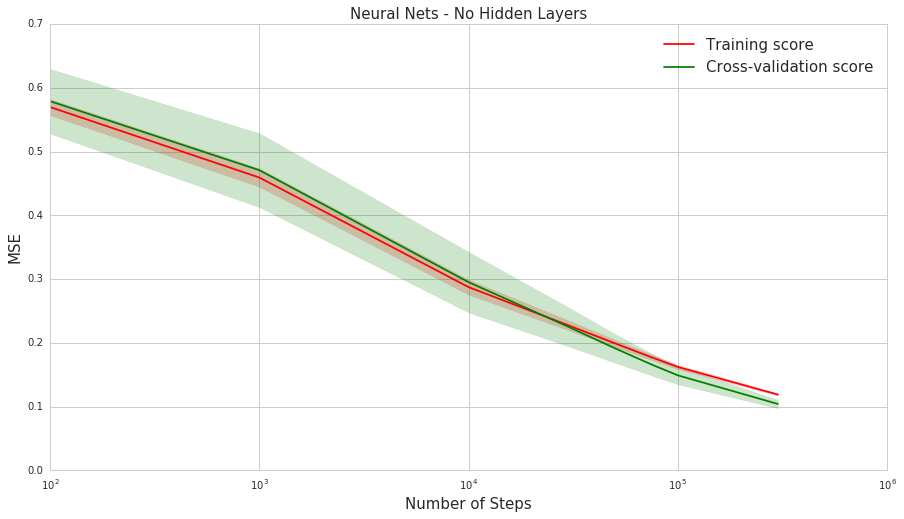

In [14]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Steps', 
                      param_range=[100,1000,10000,30000,50000,75000,100000,300000],
                      learning_list=[1e-4], 
                      hidden_list=[[]], 
                      dropout_list=[0], 
                      steps_list=[100,1000,10000,30000,50000,75000,100000,300000], 
                      batch_list=[6000],
                      plot_title='Neural Nets - No Hidden Layers', 
                      x_label='Number of Steps', 
                      y_label='MSE')

We will pick 30000 as the number of steps for use in the remaining experiments. Beyond this number, the score continues to improve... however the training & CV scores diverge. Also, the runtime increases significantly as we increase the number of steps to 300000.

### Learning Rate

Learning Rate: 0.1	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 0.01	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 0.001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 1e-05	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 1e-06	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Learning Rate: 1e-07	Hidden Units: []	Dropout: 0.0	Steps:  30000	Batch Size:  6000
Validation Curves Runtime: 0h:23m:03s


Learning Rate:      0.10	Train Score: 0.096	CV Score: 0.087
Learning Rate:      0.01	Train Score: 0.095	CV Score: 0.084
Learning Rate:      0.00	Train Score: 0.119	CV Score: 0.104
Learning Rate:      0.00	Train Score: 0.228	CV Score: 0.225
Learning Rate:      0.00	Train Score: 0.375	CV Score: 0.387
Learning Rate:      0.00	Train Score: 0.532	CV Score: 0.542
Learning Rate:      0

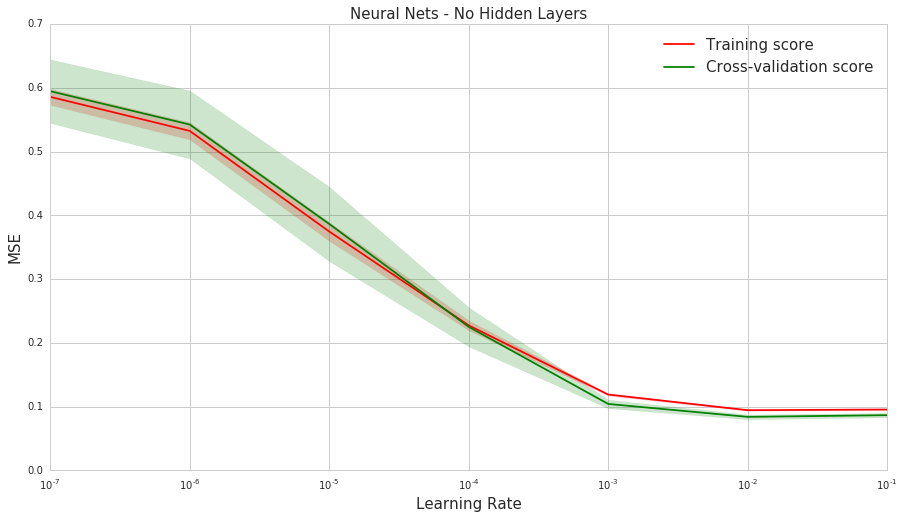

In [15]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Learning Rate', 
                      param_range=[1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7],
                      learning_list=[1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7], 
                      hidden_list=[[]], 
                      dropout_list=[0], 
                      steps_list=[30000], 
                      batch_list=[6000],
                      plot_title='Neural Nets - No Hidden Layers', 
                      x_label='Learning Rate', 
                      y_label='MSE')

We will pick 1e-4 as the learning rate for use in the remaining experiments. Beyond this number, the score continues to improve... however the training & CV scores diverge.

### Dropout

In [ ]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Dropout', 
                      param_range=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],
                      learning_list=[1e-4], 
                      hidden_list=[[]], 
                      dropout_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], 
                      steps_list=[30000], 
                      batch_list=[6000],
                      plot_title='Neural Nets - No Hidden Layers', 
                      x_label='Dropout', 
                      y_label='MSE')

Learning Rate: 0.0001	Hidden Units: []	Dropout: 0.1	Steps:  30000	Batch Size:  6000


### Batch Size

In [ ]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Batch Size', 
                      param_range=[300,1000,3000,6000,10000,15000,20000,25000,30000,50000],
                      learning_list=[?], 
                      hidden_list=[[]], 
                      dropout_list=[?], 
                      steps_list=[30000], 
                      batch_list=[300,1000,3000,6000,10000,15000,20000,25000,30000,50000],
                      plot_title='Neural Nets - No Hidden Layers', 
                      x_label='Batch Size', 
                      y_label='MSE')

## 2 Hidden Layers with Learning Rate

In [15]:
# Hyper Parameters
steps = 500001
steps = 51
learning_rate = 1e-4
batch_size = 1

# Build 2 layer fully connected DNN with 10, 10 units respectively.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
regressor = skflow.DNNRegressor(hidden_units=[10, 10], 
                                optimizer=optimizer, 
                                dropout=None)

# Fit
regressor.fit(train_dataset[:train_subset, :], 
              train_labels[:train_subset], 
              steps=steps, 
              batch_size=batch_size)

# Predict and score
train_prediction = regressor.predict(train_dataset[:train_subset, :])
score = metrics.mean_squared_error(train_prediction, train_labels[:train_subset])

print('MSE: {0:f}'.format(score))

MSE: 0.544123


In [42]:
# Predict and score
test_prediction = regressor.predict(test_dataset)
score = metrics.mean_squared_error(test_prediction, test_labels)

print('MSE: {0:f}'.format(score))

print_score(train_labels[:train_subset], train_prediction, test_labels, test_prediction)

MSE: 0.156762
		MEAN^2		R2		MAPE
TRAIN     	0.089		0.898		0.012
TEST      	0.157		0.861		0.307


## 5 Hidden Layers with Learning Rate

In [43]:
train_subset  = 8000

# Hyper Parameters
steps = 500001
learning_rate = 1e-4
batch_size = 1

# Build 5 layer fully connected DNN with 8, 16, 16, 8, 4 units respectively.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
regressor = skflow.DNNRegressor(hidden_units=[8, 16, 16, 8, 4], optimizer=optimizer, dropout=None)

# Fit
regressor.fit(train_dataset[:train_subset, :], train_labels[:train_subset], steps=steps, batch_size=batch_size)

# Predict and score
train_prediction = regressor.predict(train_dataset[:train_subset, :])
test_prediction = regressor.predict(test_dataset)

print_score(train_labels[:train_subset], train_prediction, test_labels, test_prediction)

		MEAN^2		R2		MAPE
TRAIN     	0.076		0.904		0.014
TEST      	0.187		0.834		0.287


## 5 Hidden Layers with batch gradient descent

In [47]:
train_subset = train_dataset.shape[0]

# Hyper Parameters
steps = 50001
learning_rate = 1e-4
batch_size = (train_dataset.shape[0])/10


# Build 5 layer fully connected DNN with 8, 16, 16, 8, 4 units respectively.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
regressor = skflow.DNNRegressor(hidden_units=[8, 16, 16, 8, 4], optimizer=optimizer, dropout=None)

# Fit
regressor.fit(train_dataset[:train_subset, :], train_labels[:train_subset], steps=steps, batch_size=batch_size)

# Predict and score
train_prediction = regressor.predict(train_dataset[:train_subset, :])
test_prediction = regressor.predict(test_dataset)

print_score(train_labels[:train_subset], train_prediction, test_labels, test_prediction)

		MEAN^2		R2		MAPE
TRAIN     	0.125		0.849		0.273
TEST      	0.189		0.833		0.395


In [50]:
train_subset = train_dataset.shape[0]

# Hyper Parameters
steps = 50001
learning_rate = 1e-4
batch_size = (train_dataset.shape[0])/10


# Build 5 layer fully connected DNN with 8, 16, 16, 8, 4 units respectively.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
regressor = skflow.TensorFlowDNNRegressor(hidden_units=[8, 16, 16, 8, 4], optimizer=optimizer, dropout=None)

# Fit
regressor.fit(train_dataset[:train_subset, :], 
              train_labels[:train_subset], 
              steps=steps, batch_size=batch_size, 
              logdir='/tmp/tf_examples/my_model_2/')

# Predict and score
train_prediction = regressor.predict(train_dataset[:train_subset, :])
test_prediction = regressor.predict(test_dataset)

print_score(train_labels[:train_subset], train_prediction, test_labels, test_prediction)

		MEAN^2		R2		MAPE
TRAIN     	0.125		0.849		0.273
TEST      	0.189		0.833		0.395


# NEURAL NETS - CUSTOM

## Single Layer with Learning Rate, Regularization

In [124]:
# Subset the training data for faster turnaround.
#train_subset  = (train_dataset.shape[0])/10
train_subset  = 6000

# Constants
num_weights      = train_dataset.shape[1]

# Hyper Parameters
learning_rate = 1e-4
l2loss_lambda = 1e-4

graph = tf.Graph()
with graph.as_default():

    # Load the training, validation and test data into constants
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :], dtype=tf.float64)
    tf_train_labels  = tf.constant(train_labels[:train_subset], dtype=tf.float64)
    tf_valid_dataset = tf.constant(valid_dataset, dtype=tf.float64)
    tf_test_dataset  = tf.constant(test_dataset, dtype=tf.float64)
  
    # Initialize weight matrix using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([num_weights, 1], dtype=tf.float64))
    biases  = tf.Variable(tf.zeros([1], dtype=tf.float64))
  
    # Regularization loss
    beta    = tf.Variable(tf.zeros([1], dtype=tf.float64))  
    regularization = l2loss_lambda * tf.nn.l2_loss(weights) 

 
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. 
    logits = tf.matmul(tf_train_dataset, weights) + biases
  
    # Mean squared error + Regularization
    loss = (tf.reduce_sum(tf.pow(tf.reshape(logits,[-1])-tf_train_labels, 2))/ train_subset) +  regularization
    
    
    # Minimize cost + l2_loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = logits
    valid_prediction = tf.matmul(tf_valid_dataset, weights) + biases
    test_prediction  = tf.matmul(tf_test_dataset, weights) + biases

In [125]:
num_steps = 500001

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.initialize_all_variables().run()
    print('Initialized')
    
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100000 == 0):
            print('Loss at step %d: %.3f%%' % (step, l))
            print('Training MSE: %.3f%%' % metrics.mean_squared_error(predictions, train_labels[:train_subset]))
            print('Validation MSE: %.3f%%' % metrics.mean_squared_error(valid_prediction.eval(), valid_labels))
            #print('Test MSE: %.3f%%' % metrics.mean_squared_error(test_prediction.eval(), test_labels))
            
            valid_predictions = valid_prediction.eval()
            test_predictions = test_prediction.eval()
            
    print_score(train_labels[:train_subset], predictions.reshape(-1), test_labels, test_predictions.reshape(-1))

Initialized
Loss at step 0: 6.469%
Training accuracy: 6.469%
Validation accuracy: 6.893%
Test accuracy: 8.693%
Loss at step 100000: 0.241%
Training accuracy: 0.241%
Validation accuracy: 0.129%
Test accuracy: 0.189%
Loss at step 200000: 0.158%
Training accuracy: 0.157%
Validation accuracy: 0.127%
Test accuracy: 0.197%
Loss at step 300000: 0.128%
Training accuracy: 0.127%
Validation accuracy: 0.131%
Test accuracy: 0.203%
Loss at step 400000: 0.114%
Training accuracy: 0.114%
Validation accuracy: 0.135%
Test accuracy: 0.207%
Loss at step 500000: 0.108%
Training accuracy: 0.107%
Validation accuracy: 0.137%
Test accuracy: 0.211%
		MEAN^2		R2		MAPE
TRAIN     	0.107		0.912		0.023
TEST      	0.211		0.813		0.468


## Batch Gradient Descent with Dropout

In [ ]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1, dtype=tf.float64)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape, dtype=tf.float64)
    return tf.Variable(initial)

# Constants
num_weights = train_dataset.shape[1]

# Hyper Parameters
learning_rate = 1e-5
l2loss_lambda = 0 #1e-4
batch_size = 10000
num_relus  = 64

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float64, shape=(batch_size, num_weights))
    tf_train_labels  = tf.placeholder(tf.float64, shape=(batch_size, 1))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset)
  
    # Variables.
    weights1 = weight_variable([num_weights, num_relus])
    biases1  = bias_variable([num_relus])
    weights2 = weight_variable([num_relus, 1])
    biases2  = bias_variable([1])
        
    # Regularization loss
    beta    = tf.Variable(tf.zeros([1], dtype=tf.float64))  
    l2_loss = l2loss_lambda * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))   

    # Training computation.
    to_hidden   = tf.matmul(tf_train_dataset, weights1) + biases1
    from_hidden = tf.nn.relu(to_hidden)

    # Introduce dropout before readout layer
    keep_prob = tf.placeholder(tf.float64)
    from_drop = tf.nn.dropout(from_hidden, keep_prob)
                           
    logits      = tf.matmul(from_drop, weights2) + biases2
    
    # Mean squared error + Regularization
    loss = tf.reduce_sum(tf.pow(tf.reshape(logits,[-1])-tf.reshape(tf_train_labels,[-1]), 2)/ batch_size) +  l2_loss
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = logits
    valid_prediction = tf.matmul(
                       tf.nn.relu(
                       tf.matmul(tf_valid_dataset, weights1) + biases1), weights2) + biases2
    test_prediction = tf.matmul(
                      tf.nn.relu(
                      tf.matmul(tf_test_dataset, weights1) + biases1), weights2) + biases2

In [26]:
# Hyper Parameter
num_steps = 100001
keep_probvalue = 0.5

with tf.Session(graph=graph) as session2:
    tf.initialize_all_variables().run()
    print("Initialized")
    
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels.reshape(-1,1)[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: 0.5}
        _, l, predictions = session2.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
      
        if (step % 20000 == 0):
            print('Loss at step %d: %.3f%%' % (step, l))
            print('Training MSE: %.3f%%' % metrics.mean_squared_error(predictions, train_labels.reshape(-1,1)[offset:(offset + batch_size), :]))
            print('Validation MSE: %.3f%%' % metrics.mean_squared_error(valid_prediction.eval(), valid_labels))
            #print('Test MSE: %.3f%%' % metrics.mean_squared_error(test_prediction.eval(), test_labels))
                        
            valid_predictions = valid_prediction.eval()
            test_predictions = test_prediction.eval()
            
    print_score(train_labels[offset:(offset + batch_size)], predictions.reshape(-1), test_labels, test_predictions.reshape(-1))

Initialized
Loss at step 0: 1.035%
Training MSE: 1.035%
Validation MSE: 1.451%
Loss at step 20000: 0.511%
Training MSE: 0.511%
Validation MSE: 0.508%
Loss at step 40000: 0.252%
Training MSE: 0.252%
Validation MSE: 0.351%
Loss at step 60000: 0.187%
Training MSE: 0.187%
Validation MSE: 0.306%
Loss at step 80000: 0.120%
Training MSE: 0.120%
Validation MSE: 0.278%
Loss at step 100000: 0.163%
Training MSE: 0.163%
Validation MSE: 0.257%
		MEAN^2		R2		MAPE
TRAIN     	0.163		0.808		0.033
TEST      	0.196		0.827		0.322
